# Viewing an MSSA analysis previously computed on a compute node

Begin with the usual imports

In [1]:
import os
import copy
import yaml
import time
import pyEXP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from os.path import exists

plt.rcParams['figure.figsize'] = [12, 9]

### Switch to the working directory
I like to be explicit about my working directory but you don't need to do this here.  It would be sufficient to simply pass the full path to the coefficient factory below.

In [2]:
# os.chdir('/data/Nbody/Run101')

### Read the EXP config files and generate the bases

In [29]:
# Read the basis info from the EXP file
#
exp_config = 'step3_try25.yml'
stride     = 4
npc        = 40
size       = 0.02
npix       = 10
wp         = 2
tmax       = 8.0

# Open and read the EXP yaml file.  Get the runtag. Create the bases
# and construct coefficient file names
#
config = {}
basis  = {}
fcoef  = {}
runtag = ""

with open(exp_config, 'r') as f:
    yaml_db = yaml.load(f, Loader=yaml.FullLoader)

    # Get the runtag
    #
    runtag = yaml_db['Global']['runtag']
    print("\nRuntag from {} is: {}".format(exp_config, runtag))


    # Grab YAML force stanzas for all components
    #
    for v in yaml_db['Components']:
        comp = v['name']
        config[comp] = yaml.dump(v['force'])
               
        # Construct the basis instance
        #
        basis[comp] = pyEXP.basis.Basis.factory(config[comp])

        # Get the coefficient files
        fcoef[comp] = 'coefs/outcoef.{}.{}.h5'.format(comp, runtag)
        print("\nCoef file is:", fcoef[comp])


Runtag from step3_try25.yml is: run45_3
---- SLGridSph::read_cached_table: trying to read cached table . . .

Coef file is: coefs/outcoef.dark.run45_3.h5
---- SLGridSph::read_cached_table: Success!!
---- EmpCylSL::cache_grid: file read successfully
---- EmpCylSL::read_cache: table forwarded to all processes

Coef file is: coefs/outcoef.star.run45_3.h5


Slave    0: tables allocated, MMAX=6


## Read the coefficients and the MSSA files

In [30]:
# Just do star component for now
#
comp = 'star'
size = 0.05
npix = 50

coefs0 = pyEXP.coefs.Coefs.factory(fcoef[comp], stride=stride, tmax=tmax)
coefs  = coefs0.deepcopy()

# Make some custom [m, n] pairs
keylst = {}
for m in range(7):
    keylst[m] = coefs.makeKeys([m])


ssa = {}
ev  = {}
cum = {}

totPow = 0.0

for m in range(5):

    config = {coefs.getName(): (coefs, keylst[m], keylst[0])}

    window = int(len(coefs.Times())/wp)

    flags ="""
---
RedSym : true
# totPow : true
# noMean : true
...
"""
    print("Window={} PC number={}".format(window, npc))

    startTime = time.time()
    ssa[m] = pyEXP.mssa.expMSSA(config, window, npc, flags)
    file = 'mssa/{}_{}_{}_s{}_w{}_t{}'.format(runtag+'_fi', comp, m, int(stride), int(wp), int(tmax))
    print('File={}'.format(file))
    if os.path.exists(file+"_mssa.h5"):
        print('Restore file={}'.format(file))
        ssa[m].restoreState(file)
        totPow += ssa[m].getTotPow()
        ev[m] = ssa[m].eigenvalues()
        cum[m] = ssa[m].cumulative()
    else:
        raise Exception("Could not open file: {}_mssa.h5".format(file))
#    if not os.path.exists(file+"_mssa.h5"):
#        ssa[m].saveState(file)
#        print('Computed eigenvalues in {:6.2f} seconds'.format(time.time() - startTime))

Window=500 PC number=40
File=mssa/run45_3_fi_star_0_s4_w2_t8
Restore file=mssa/run45_3_fi_star_0_s4_w2_t8
Window=500 PC number=40
File=mssa/run45_3_fi_star_1_s4_w2_t8
Restore file=mssa/run45_3_fi_star_1_s4_w2_t8
Window=500 PC number=40
File=mssa/run45_3_fi_star_2_s4_w2_t8
Restore file=mssa/run45_3_fi_star_2_s4_w2_t8
Window=500 PC number=40
File=mssa/run45_3_fi_star_3_s4_w2_t8
Restore file=mssa/run45_3_fi_star_3_s4_w2_t8
Window=500 PC number=40
File=mssa/run45_3_fi_star_4_s4_w2_t8
Restore file=mssa/run45_3_fi_star_4_s4_w2_t8


## Plot the eigenvalues

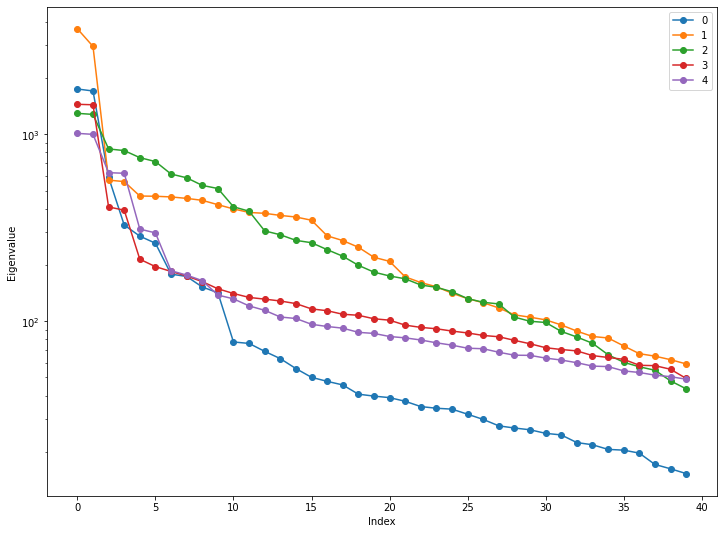

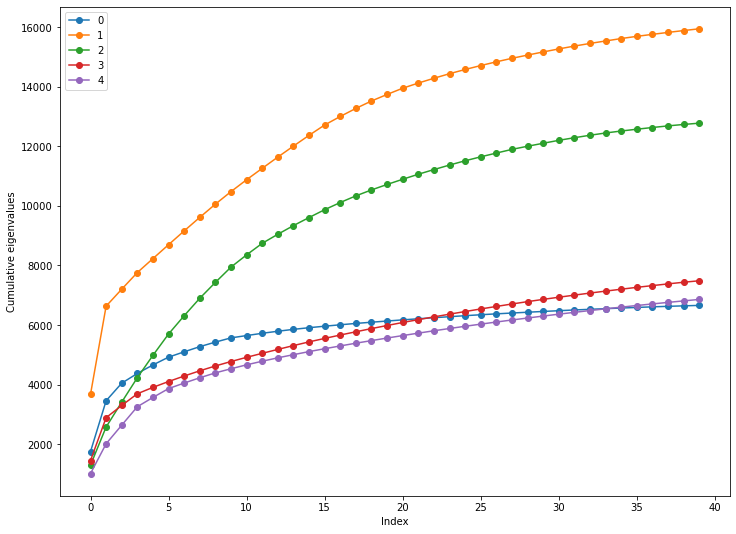

In [5]:
# Make a plot of the eigenvalues
#
for m in range(5):
    plt.semilogy(ev[m], '-o', label=str(m))
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.show()

for m in range(5):
    plt.plot(cum[m], '-o', label=str(m))
plt.xlabel('Index')
plt.ylabel('Cumulative eigenvalues')
plt.legend()
plt.show()

## Let's look at some PCs

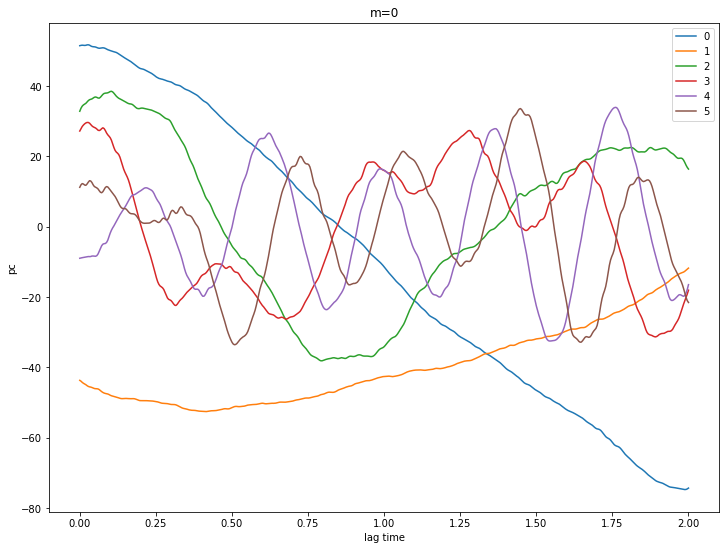

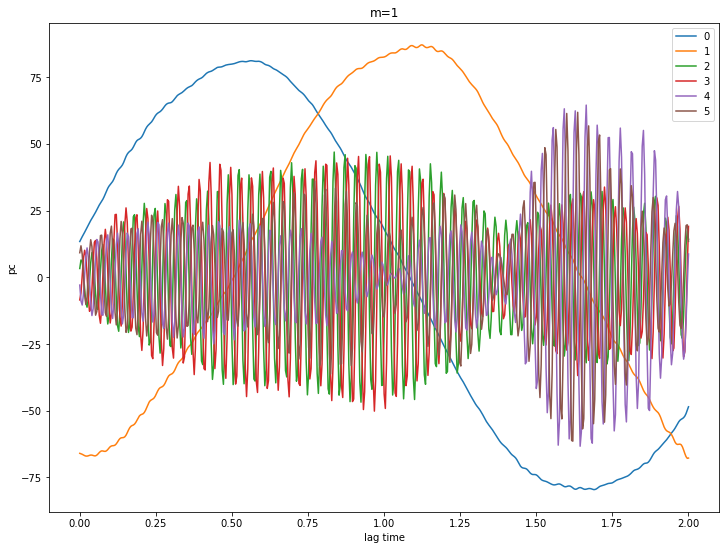

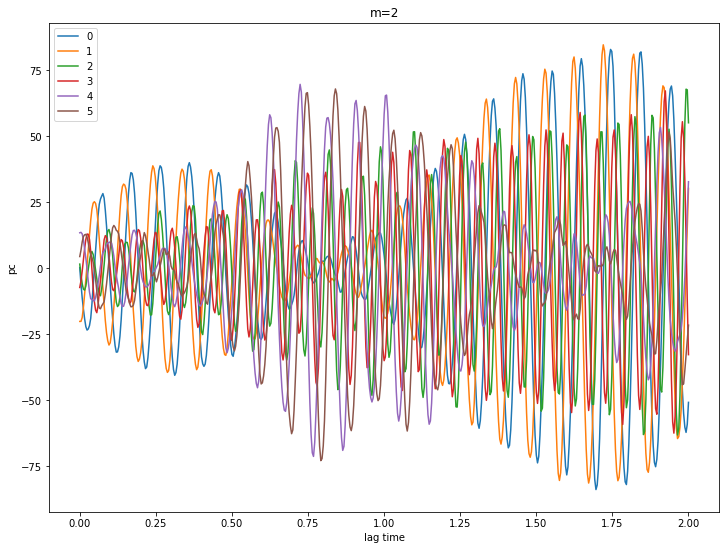

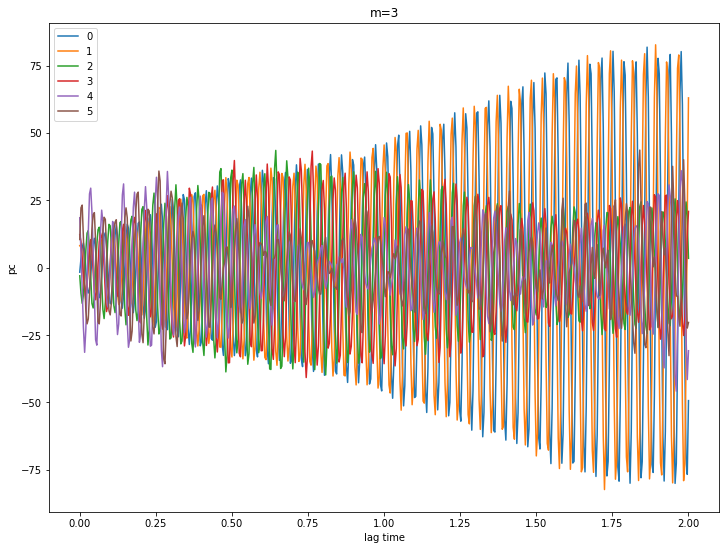

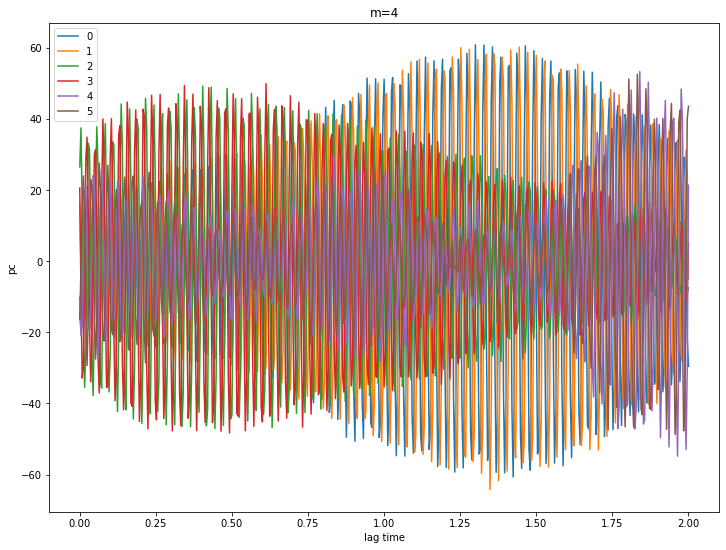

In [6]:
for m in range(5):
    pcs = ssa[m].getPC()
    ntim = pcs.shape[0]
    for n in range(0,6):
        plt.plot(coefs.Times()[0:ntim], pcs[:,n], label=str(n))
    plt.xlabel('lag time')
    plt.ylabel('pc')
    plt.legend()
    plt.title('m={}'.format(m))
    plt.show()

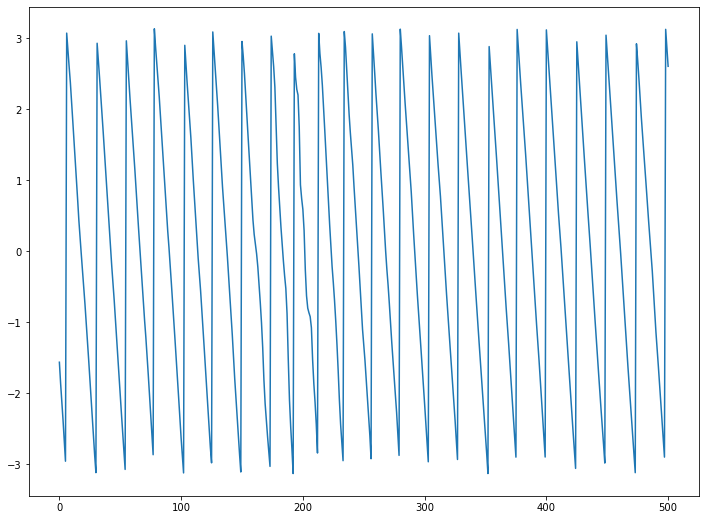

In [7]:
pcs = ssa[2].getPC()
plt.plot(np.arctan2(pcs[:,1], pcs[:,0]))
plt.show()

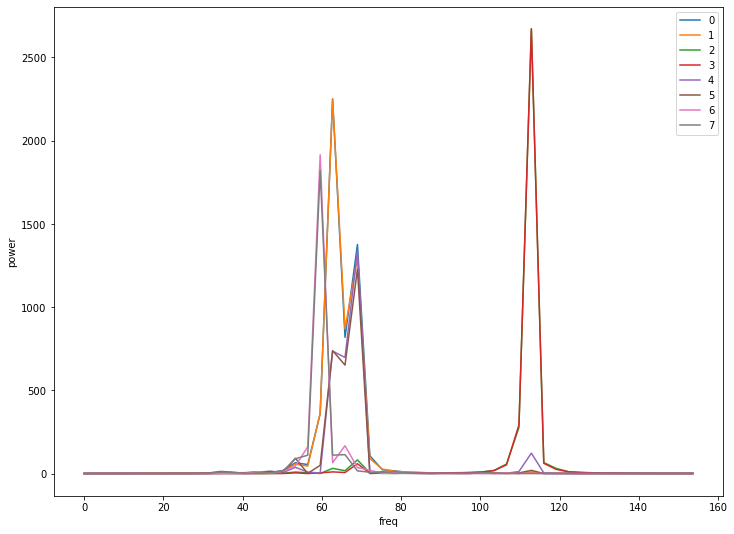

In [8]:
freq, dft = ssa[2].pcDFT()
for n in range(0,8):
    plt.plot(freq[0:50], dft[0:50,n], label=str(n))
plt.legend()
plt.xlabel('freq')
plt.ylabel('power')
plt.show()

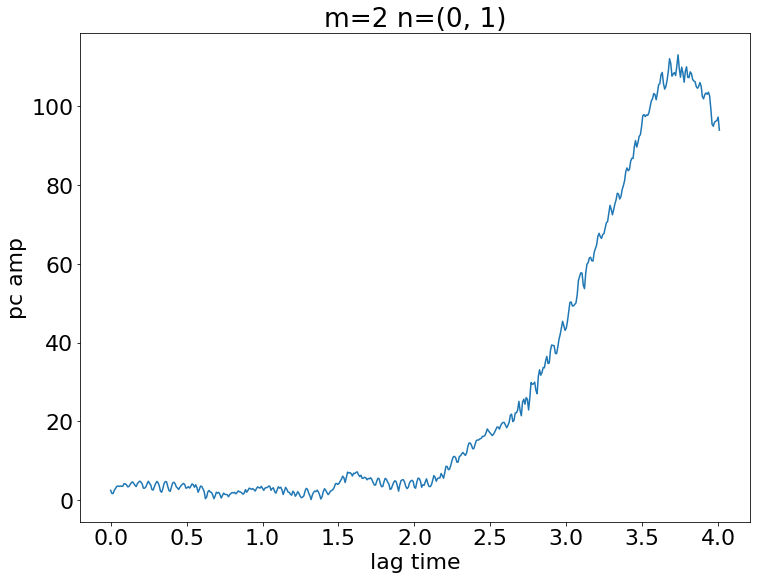

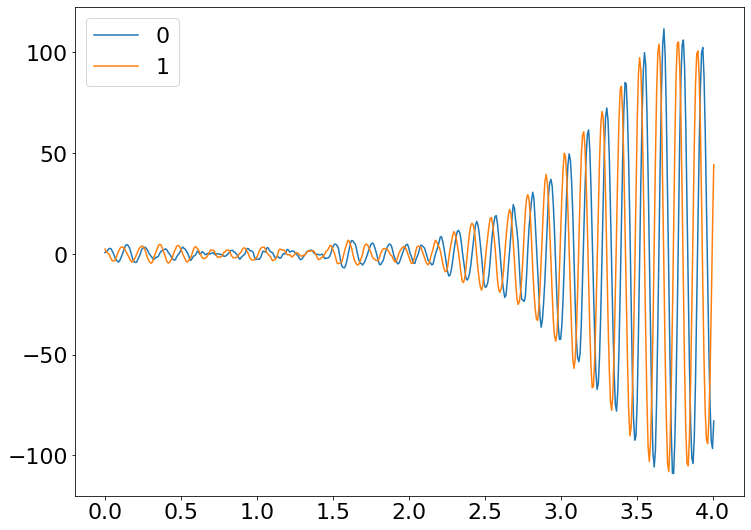

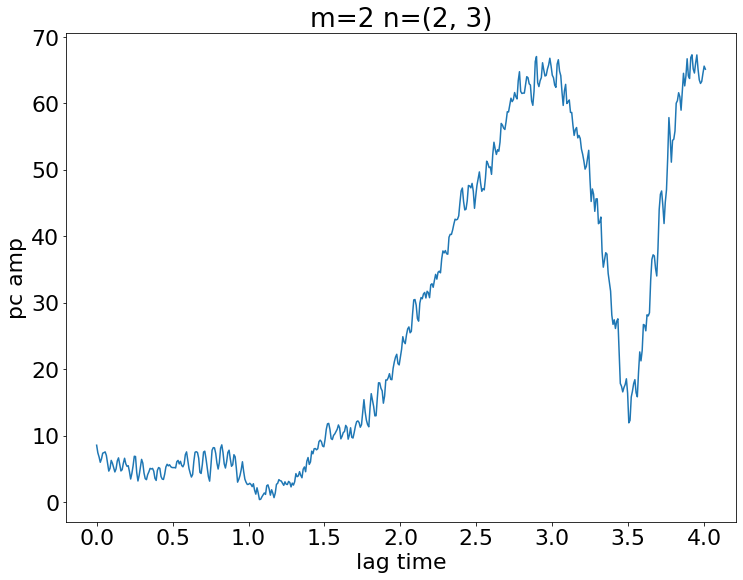

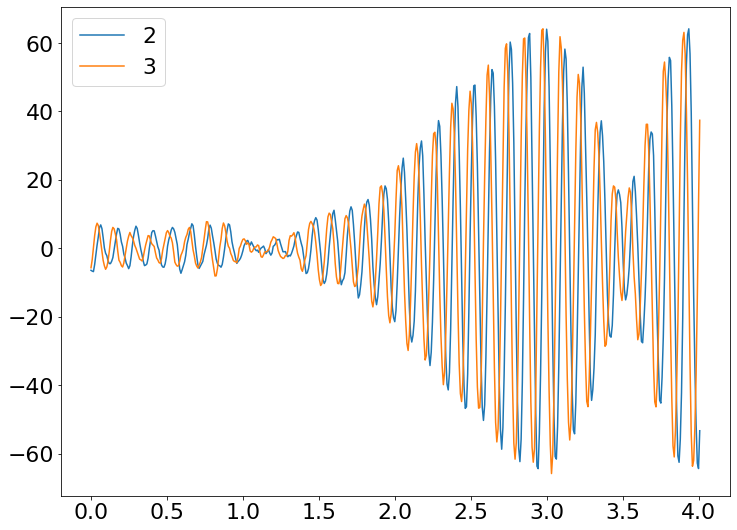

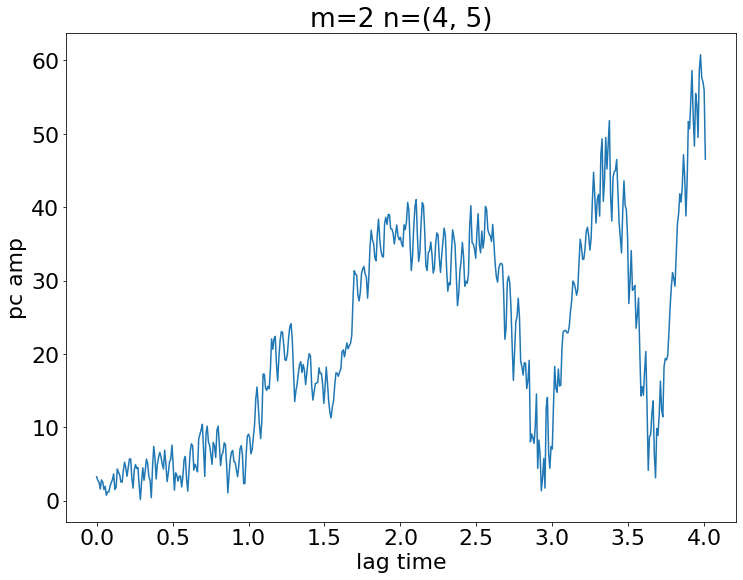

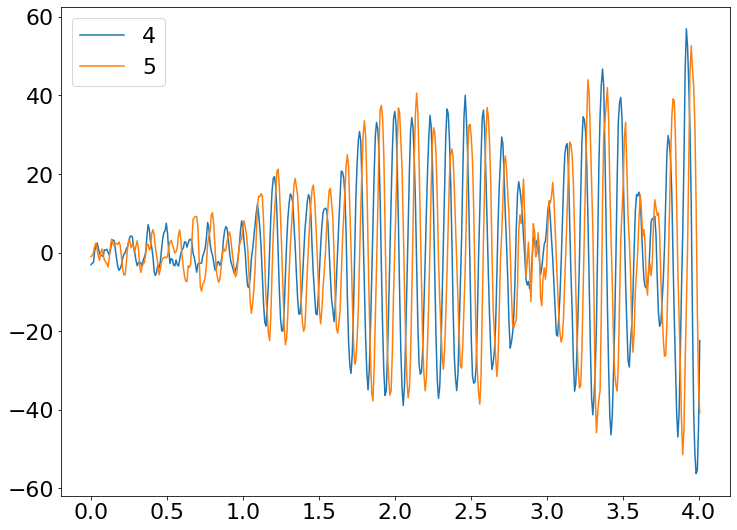

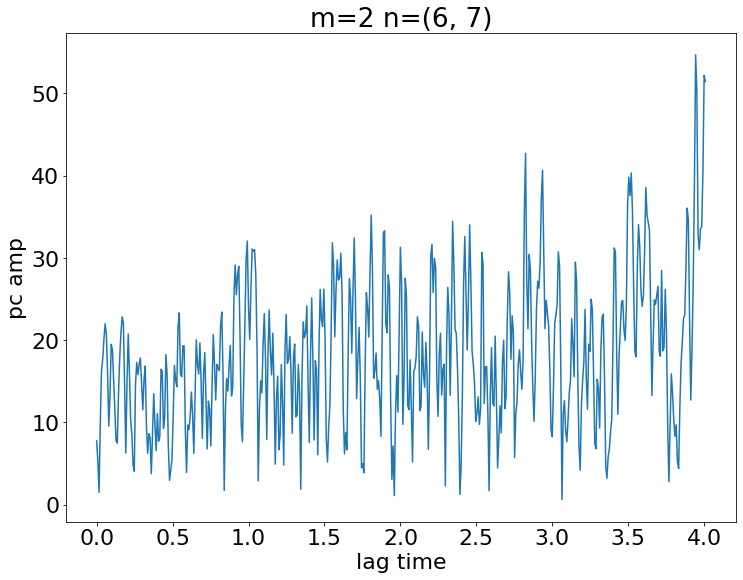

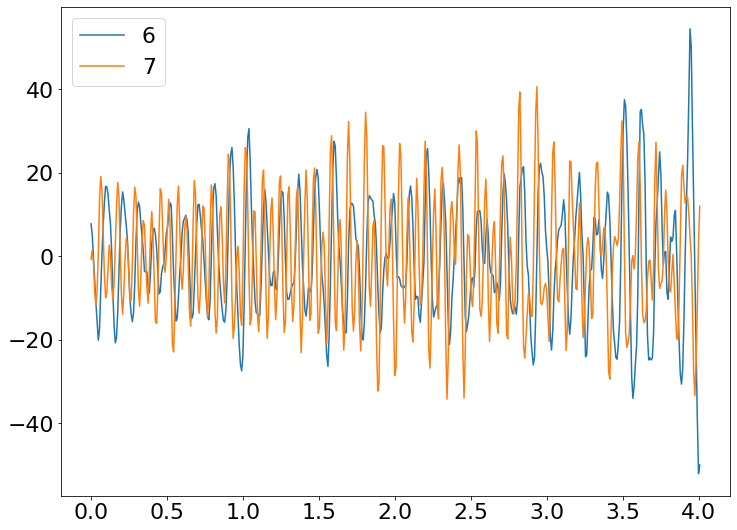

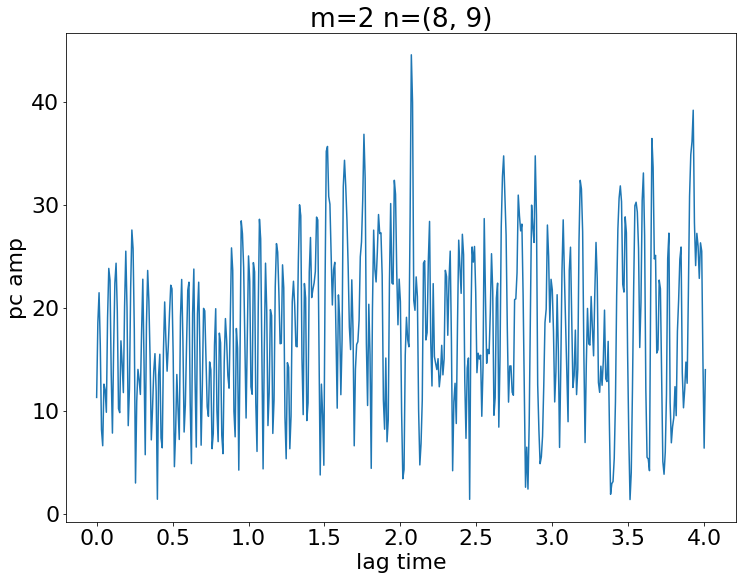

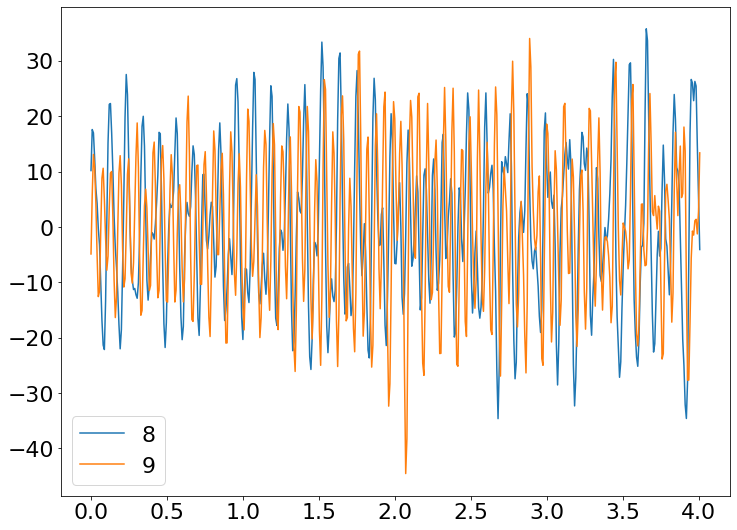

In [31]:
pcs = ssa[2].getPC()
ntim = pcs.shape[0]
for n in range(5):
    n1 = n*2+0
    n2 = n*2+1
    plt.plot(coefs.Times()[0:ntim], np.sqrt(pcs[:,n1]**2 + pcs[:,n2]**2))
    plt.xlabel('lag time')
    plt.ylabel('pc amp')
    plt.title('m={} n=({}, {})'.format(2, n1, n2))
    plt.show()
    plt.plot(coefs.Times()[0:ntim], pcs[:, n1], label=str(n1))
    plt.plot(coefs.Times()[0:ntim], pcs[:, n2], label=str(n2))
    plt.legend()
    plt.show()

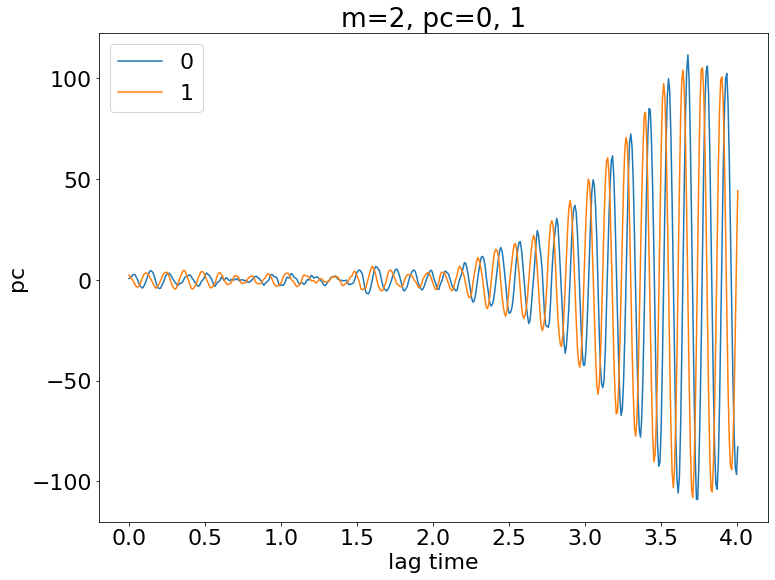

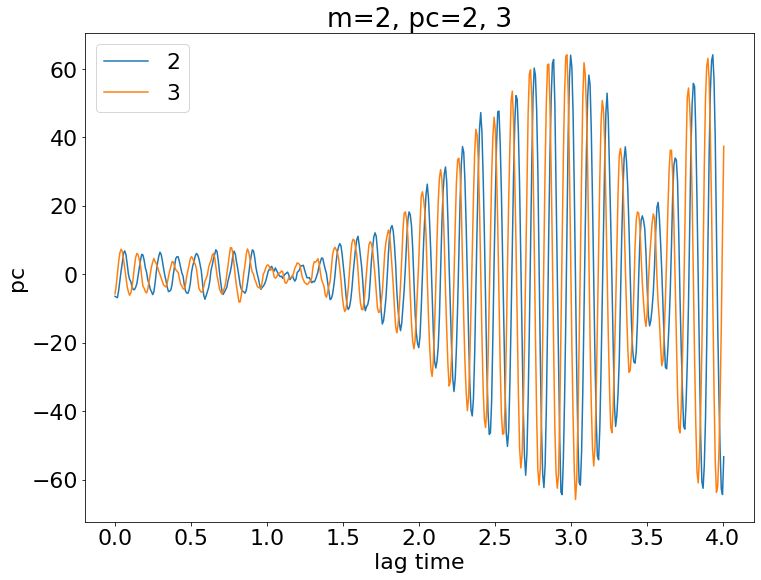

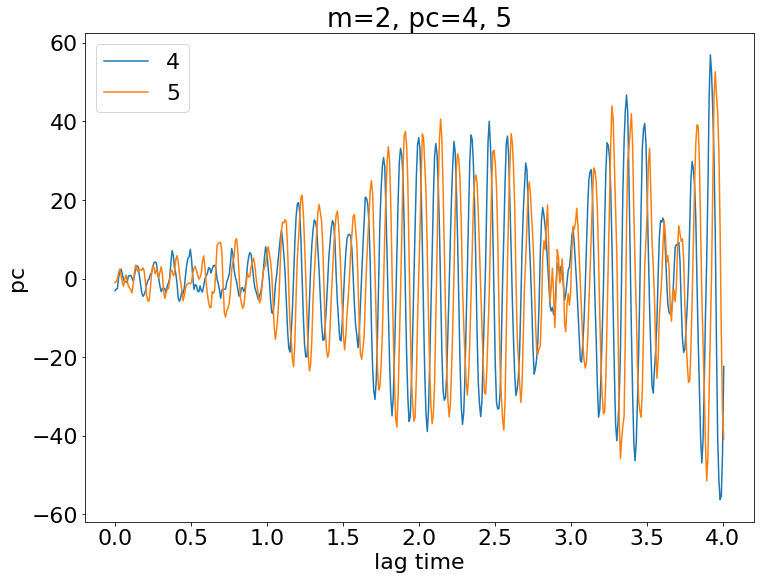

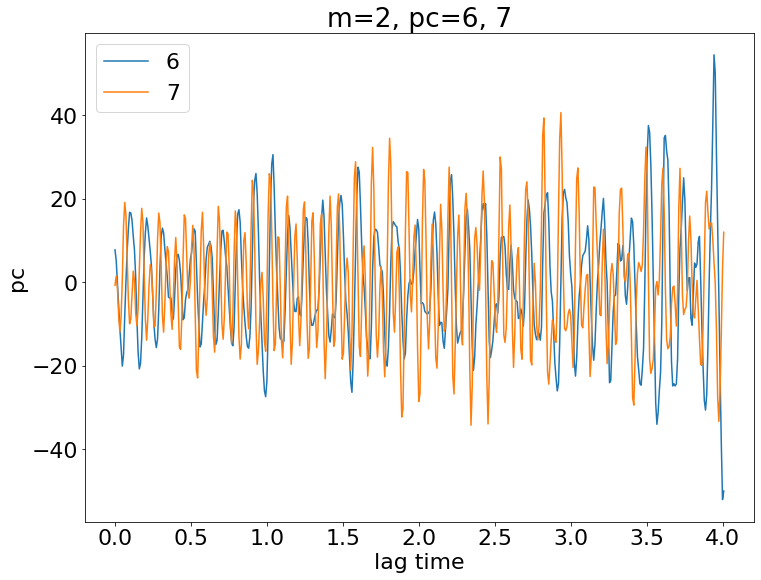

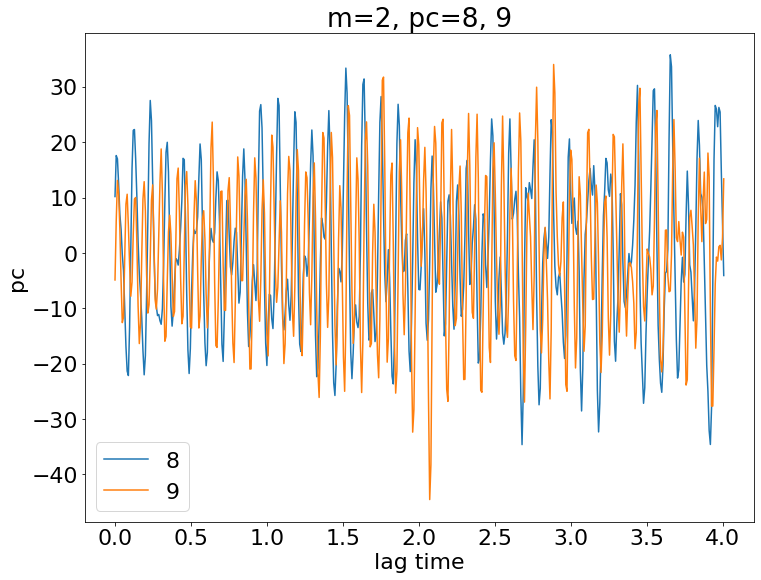

In [32]:
pcs = ssa[2].getPC()
ntim = pcs.shape[0]
for k in range(5):
    mm = [2*k+0, 2*k+1]
    for n in mm:
        plt.plot(coefs.Times()[0:ntim], pcs[:,n], label=str(n))
    plt.xlabel('lag time')
    plt.ylabel('pc')
    plt.legend()
    plt.title('m={}, pc={}, {}'.format(2, mm[0], mm[1]))
    plt.show()

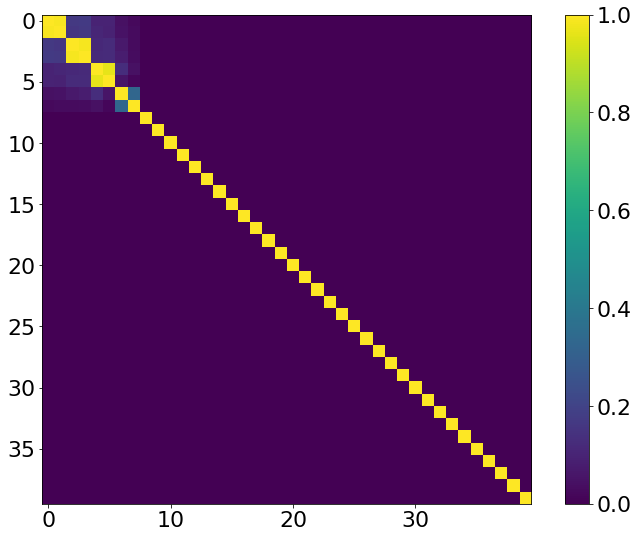

In [33]:
ssa[2].reconstruct([*range(8)])
wcorr = ssa[2].wCorrAll()
p = plt.imshow(wcorr[0:40, 0:40])
plt.colorbar(p)
plt.show()

In [34]:
mm = [2]
for m in mm:
    ssa[m].reconstruct([0, 1])
    # ssa[m].reconstruct([4, 5, 6, 7])

In [35]:
coefs.zerodata()
for m in mm:
    ssa[m].getReconstructed()

print(len(coefs.Times()))

1001


### Check by making some surface renderings
Uses the final time slice but you could easily loop through all of them to make a movie, etc.

In [26]:
# Make the coefficients by the factory method
#

print('The coefficient time list is {} slices in [{}, {}]'.format(len(coefs.Times()), coefs.Times()[0], coefs.Times()[-1]))
#
times = coefs.Times()[-2:-1]
pmin  = [-size, -size, 0.0]
pmax  = [ size,  size, 0.0]
grid  = [  npix, npix,   0]

print('Creating surfaces with times:', times)

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

print('Created fields instance')

surfaces = fields.slices(basis[comp], coefs)

print('Created surfaces')

print("We now have the following [time field] pairs")
final = 0.0
for v in surfaces:
    print('-'*40)
    for u in surfaces[v]:
        print("{:8.4f}  {}".format(v, u))
        final = v    

The coefficient time list is 1000 slices in [0.0, 3.996]
Creating surfaces with times: [3.992]
Created fields instance
Created surfaces
We now have the following [time field] pairs
----------------------------------------
  3.9920  d
  3.9920  d0
  3.9920  d1
  3.9920  dd
  3.9920  fp
  3.9920  fr
  3.9920  ft
  3.9920  p
  3.9920  p0
  3.9920  p1


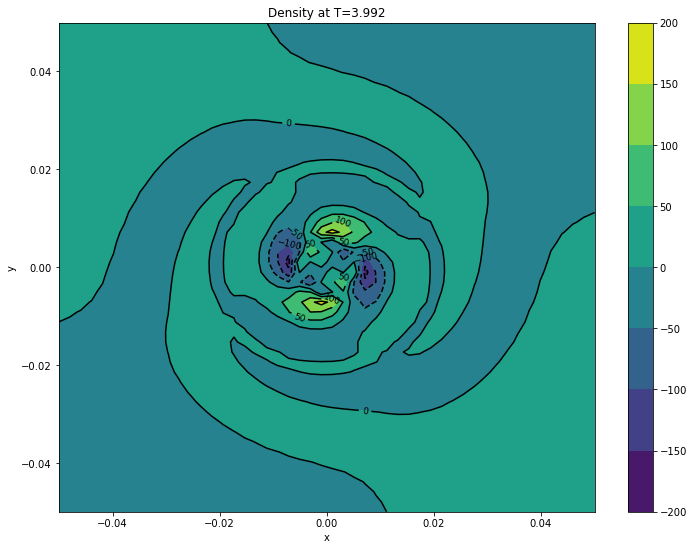

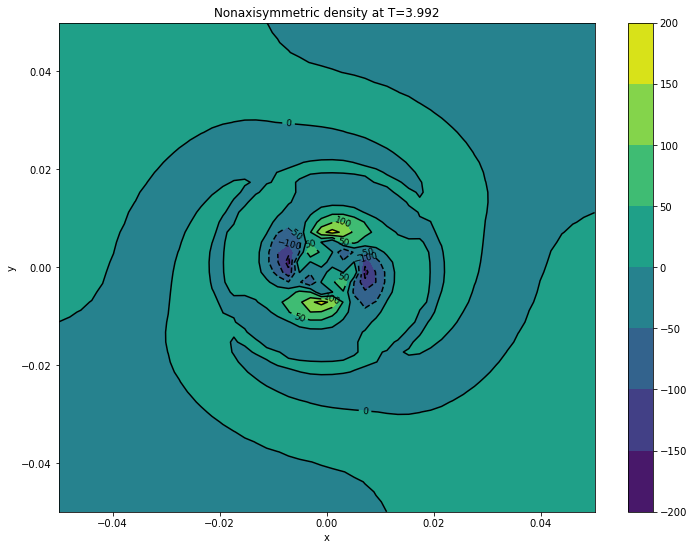

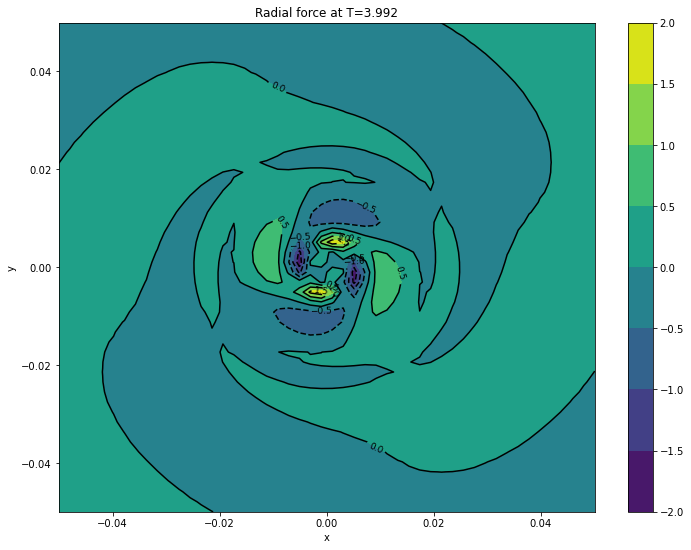

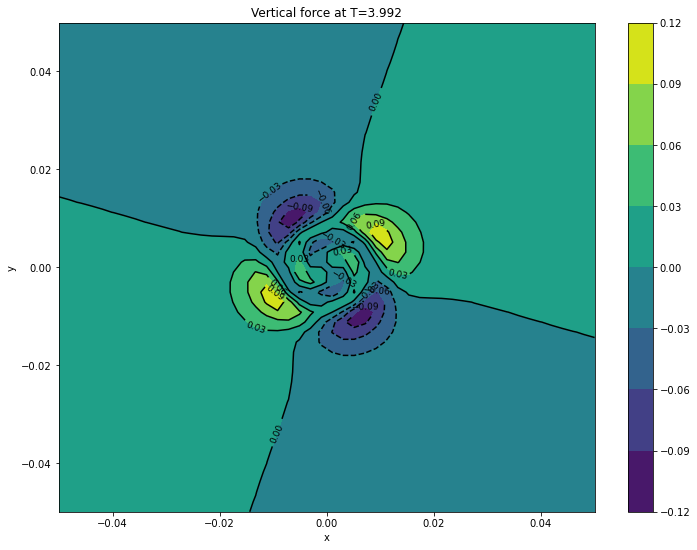

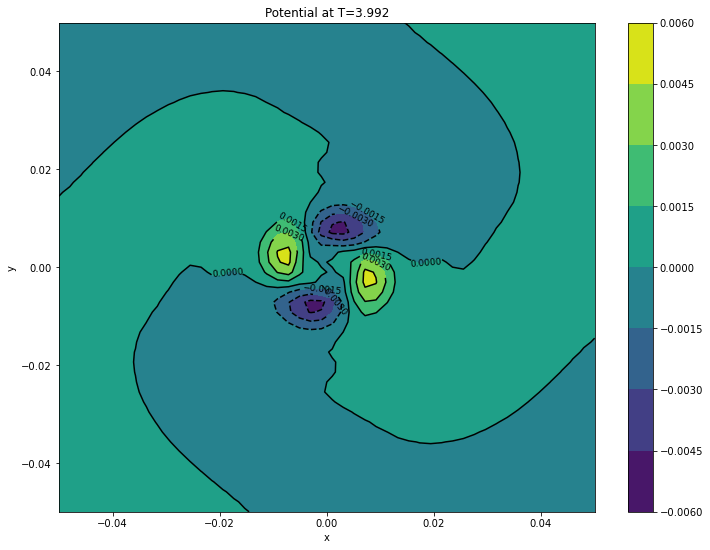

In [15]:
# Print the potential image at the final time
# 
nx = surfaces[final]['d'].shape[0]
ny = surfaces[final]['d'].shape[1]

x = np.linspace(pmin[0], pmax[0], nx)
y = np.linspace(pmin[1], pmax[1], ny)
xv, yv = np.meshgrid(x, y)

# cont1 = plt.contour(xv, yv, surfaces[final]['d'].transpose(), colors='k', locator=ticker.LogLocator())
cont1 = plt.contour(xv, yv, surfaces[final]['d'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
# cont2 = plt.contourf(xv, yv, surfaces[final]['d'].transpose(), locator=ticker.LogLocator())
cont2 = plt.contourf(xv, yv, surfaces[final]['d'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Density at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['d1'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['d1'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nonaxisymmetric density at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['fr'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['fr'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Radial force at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['ft'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['ft'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vertical force at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['p1'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['p1'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential at T={}'.format(final))
plt.show()

## Okay, now make a movie

In [36]:
# %%script false --no-raise-error

times = coefs.Times()[0:-1]
size = 0.05

pmin  = [-size, -size, 0.0]
pmax  = [ size,  size, 0.0]
grid  = [ npix,  npix,   0]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

print('Created fields instance')

comp = 'star'

surfaces = fields.slices(basis[comp], coefs)

# Get the shape
keys = list(surfaces.keys())
nx = surfaces[keys[0]]['p'].shape[0]
ny = surfaces[keys[0]]['p'].shape[1]

# Make the mesh
x = np.linspace(pmin[0], pmax[0], nx)
y = np.linspace(pmin[1], pmax[1], ny)
xv, yv = np.meshgrid(x, y)

plt.rcParams.update({'font.size': 22})

# Fix the contour levels to prevent jitter in the movie (linear scaling)
mval  = 200.0
mscl  = 50.0

cbar1 = np.arange(-1.6, 1.6+0.01, 0.1)
cbar2 = np.arange(-1.6, 1.6+0.01, 0.2)

# Frame counter
icnt = 0
cmap = copy.copy(plt.colormaps['viridis'])

N = cmap.N
cmap.set_under(cmap(1))
cmap.set_over(cmap(N-1))

# Iterate through the keys
for v in keys:
    fig, ax = plt.subplots(1, 1, figsize=(24, 20))
    
    mat = copy.deepcopy(surfaces[v]['d'])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            mat[i, j] = np.arctan(mat[i, j]/mscl)
            
    cont1 = ax.contour(xv, yv, mat.transpose(), cbar2, colors='k')
    # You can label the contours inline by uncommenting the next two lines...
    # ax[0].clabel(cont1, fontsize=9, inline=True)
    # cont2 = ax.contourf(xv, yv, surfaces[v]['d'].transpose(), cbar2, vmin=cbar2[0], vmax=cbar2[-1])
    cont2 = ax.contourf(xv, yv, mat.transpose(), cbar1) # locator=ticker.LogLocator())
    plt.colorbar(cont2, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('T={:4.3f}'.format(v))
    
    fig.savefig('{}_mssa_{}_{}_{:04d}.png'.format(comp, runtag, 24, icnt), dpi=75)
    plt.close()

    icnt += 1

Created fields instance


## Make a mp4 file from the frames using ffmpeg

This only work if you have 'ffmpeg' installed, of course ...

In [37]:
# %%script false --no-raise-error

os.system('ffmpeg -y -i \'{0}_mssa_{1}_{2}_%04d.png\' mssa_{0}_{1}_{2}.mp4'.format(comp, runtag, 24))

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

0

In [18]:
## Plot m=1 coefficient contributions

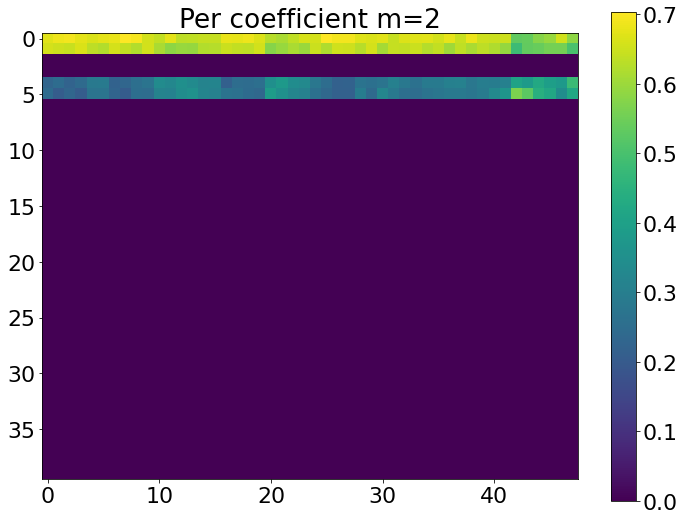

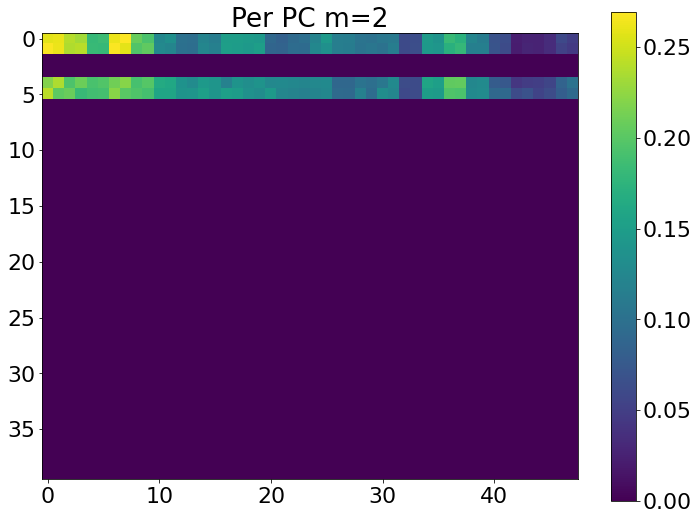

In [19]:
for m in mm:
    retF, retG = ssa[m].contrib()

    pf = plt.imshow(retF)
    plt.colorbar(pf)
    plt.title('Per coefficient m={}'.format(m))
    plt.show()

    pg = plt.imshow(retG)
    plt.colorbar(pg)
    plt.title('Per PC m={}'.format(m))
    plt.show()